In [1]:
import numpy as np
from scipy.ndimage import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.hub
import torch.utils.data as Data

from torchvision.datasets import *
import torchvision
import torchvision.transforms as transforms
import albumentations as A

import random
import os
import re
import time
import datetime
from PIL import *
import cv2
from cv2 import *

import copy

import argparse

import sys
sys.path.insert(0, '/root/research/jupyter/git-metallic-5-5/metallic')

from utility.output import *
from utility.metrics import computeMetrics
from utility.plot import plotResultCurve
from utility.mysenet import se_resnet


from efficientnet_pytorch import EfficientNet

import swats
from sklearn.metrics import *
import warnings

warnings.filterwarnings('ignore')

In [2]:
torch.cuda.is_available()

True

In [3]:
#### define save file path
WORK_DIR = r'/root/research/jupyter/git-metallic-5-5/metallic'
MODEL_SAVE_PATH = WORK_DIR+'/model'
isDetect = True

PATCH_SIZE = 256
#### dataset path
if isDetect:
    DATA_PATH = r'/root/research/jupyter/git-metallic-5-5/metallic/' + 'detect/' + str(PATCH_SIZE)
else:
    DATA_PATH = r'/root/research/jupyter/git-metallic-5-5/metallic/traindata'



def getCurrentTime():
    return datetime.datetime.strftime(datetime.datetime.fromtimestamp(time.time()),format='%Y-%m-%d-%H-%M-%S')

#### model checkpoint
def checkpoint(model, optimizer, epoch, useTimeDir=False):
    global TAG
    state = {'net':model.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epoch}
    model_name = str(model).split('(')[0]
    if useTimeDir is True:
        TAG = getCurrentTime()
        savePath = MODEL_SAVE_PATH+'/'+TAG
        os.mkdir(savePath)
    else:
        savePath = MODEL_SAVE_PATH
    dir = os.path.join(savePath,model_name+'_model.pth')
    torch.save(state, dir)
    return savePath if useTimeDir else None

#### model loading
def modelrestore(model):
    model_name = str(model).split('(')[0]
    dir = os.path.join(MODEL_SAVE_PATH,model_name+'_model.pth')
    checkpoint = torch.load(dir)
    model.load_state_dict(checkpoint['net'])
    epoch = checkpoint['epoch'] + 1
    return model, epoch


### global params
def saveParameters(root_path):
    params = {
        'DATA_PATH': DATA_PATH,
        'PATCH_SIZE': PATCH_SIZE,
        'EPOCH': EPOCH,
        'BATCH_SIZE': BATCH_SIZE,
        'NUM_CLASS': NUM_CLASS,
        'CV': CV,
        'SCHEDULE_EPOCH': SCHEDULE_EPOCH,
        'SCHEDULE_REGRESS': SCHEDULE_REGRESS,
        'USE_SWITCH_SGD': USE_SWITCH_SGD,
        'OPTIM_CHANGE_STAGE': OPTIM_CHANGE_STAGE if 'OPTIM_CHANGE_STAGE' in globals() else '',
        '_PARTIAL_TRAIN': _PARTIAL_TRAIN,
        '_PARTIAL_TRAIN_RATIO': _PARTIAL_TRAIN_RATIO,
        '_NET_FREEZE': _NET_FREEZE,
        '_NET_NO_GRAD':  _NET_NO_GRAD,
        'LR': LR,
        'train_ratio': train_ratio,
        'NET_NAME':NET_NAME,
        'USE_PRETRAIN':USE_PRETRAIN,
        'use_Scheduler':use_Scheduler,
        'transforms_aug':str(data_transform_aug.transforms),
        'SCHEDULE_MILESTONE':str(SCHEDULE_MILESTONE),
        'OPTIMER': OPTIMER,
        'isDetect': isDetect,
    }
    with open(os.path.join(root_path,'params.txt'),'w+') as f:
        json.dump(params,f)
    print('parameters stored')
    return

def saveText(root_path):
    global GLOBAL_TEXT_RECORD
    with open(os.path.join(root_path,'record-text.txt'),'w+') as f:
        text = GLOBAL_TEXT_RECORD
        f.write(text)
    print('global text recorded')
    return

def recordNotes(root_path, content, tag):
    global GLOBAL_TEXT_RECORD
    with open(os.path.join(root_path,'record-text.txt'),'a+') as f:
        text = tag+'\n'+GLOBAL_TEXT_RECORD+'\n'+content
        f.write(text)
    print('notes recorded')
    return

#### compute sample weights for balancing data
#### @dataset folder.img
from collections import *
def compute_sample_balanced_weight(dataset):
    
    all_labels = Counter(list(map(lambda x:x[1],dataset)))

    counts = sorted(list(all_labels.values()), reverse=True)
    N = np.sum(counts[1:]) + np.max(counts[1:])
    
    fraction = np.max(counts[1:])
    newN = len(all_labels)*fraction
    for k,v in all_labels.items():
        all_labels[k] = N/v

    weights = list(map(lambda x:all_labels[x[1]],dataset))
    weights = torch.DoubleTensor(weights)
    
    return weights,newN



def getModel(NUM_CLASS,pretrain=False,froze=False,name='se_resnet50',repo='moskomule/senet.pytorch'):
    
    if not pretrain:
        
        if 'efficientnet' in name:
            model = EfficientNet.from_name(name)
            model._fc.out_features = NUM_CLASS
            return model
        else:
            if 'vgg16' in name:
                model = torch.hub.load('pytorch/vision', 'vgg16', pretrained=False)
                return model
            elif 'csse' in name:
                model = se_resnet.se_resnet50(num_classes=NUM_CLASS, pretrained=False)
                return model
            return torch.hub.load(
                    repo,
                    name,
                    num_classes=NUM_CLASS,
                    pretrained=False
            )
    
    else:
        
        if 'efficientnet' in name:
            model = EfficientNet.from_pretrained('efficientnet-b7')
        elif 'vgg16'==name:
            model = torch.hub.load('pytorch/vision', 'vgg16', pretrained=True)
        else:
            model = torch.hub.load(
                repo,
                NET_NAME,
                pretrained=True
            )
        
        if froze:
            for param in model.parameters():
                param.requires_grad = False
        
        if name=='se_resnet50':
            for param in model.layer4.parameters():
                param.requires_grad = True
            layers = [
                nn.Linear(in_features=2048, out_features=NUM_CLASS, bias=True)
            ]
            model.fc = nn.Sequential(*layers)
        elif name=='efficientnet_b3':
            model.classifier = nn.Linear(in_features=1536, out_features=NUM_CLASS, bias=True)
        elif name=="efficientnet-b7":
            model._fc = nn.Linear(in_features=2560, out_features=NUM_CLASS, bias=True)
        elif name=='vgg16':
            model.classifier[-1] = nn.Linear(in_features=4096, out_features=NUM_CLASS, bias=True)

        return model


### extract whole-image id
def parentid_from_fname(fname):
    parentid = list(filter(lambda x:len(x), re.split('(-\$[0-9]+)', fname)))[0]
    return parentid

### extract coords
def coords_from_fname(fname):
    coord = list(filter(lambda x:len(x), re.split('(-\$[0-9]+)', fname)))[-3:-1]
    coord = tuple(map(lambda x:int(x.lstrip('-$')), coord))
    return coord

### generate train test indices of full_dataset.samples
### NOTE: all patches of a single image should be in either @train or @test
def get_train_test_indices(full_dataset):
    global mapping_coord, fname_train, fname_test
    
    paths_data = list(map(lambda x:os.path.split(x[0])[-1],full_dataset.samples))

    mapping_idx = {}
    for idx in range(total_size):
        mapping_idx[os.path.split(full_dataset.samples[idx][0])[-1]] = idx

    counter_origin_fnames = Counter(map(lambda x:parentid_from_fname(x), paths_data))
    
    if isDetect:
        mapping_coord = { 
            parentid:{ 
                ofname:coords_from_fname(ofname)
                for ofname in filter(
                    lambda x:x[:len(parentid)]==parentid, 
                    paths_data
                )
            } 
            for parentid in counter_origin_fnames.keys() 
        }
    origin_fnames = list(counter_origin_fnames.keys())
    origin_fnames = np.random.permutation(origin_fnames)

    ct = 0
    record_fnames = []
    for idx in range(len(origin_fnames)):
        f = origin_fnames[idx]
        if ct + counter_origin_fnames[f] < total_size - train_size:
            record_fnames.append(f)
            ct += counter_origin_fnames[f]
        else:
            if ct + counter_origin_fnames[f]//2 < total_size - train_size:
                record_fnames.append(f)
                ct += counter_origin_fnames[f]
            else:
                break

    test_indices = []
    for idx, x in enumerate(paths_data):
        parent = parentid_from_fname(x)
        if parent in record_fnames:
            test_indices.append(mapping_idx[x])

    train_indices = list(set([i for i in range(total_size)]) - set(test_indices))

    fname_train = list(set(counter_origin_fnames.keys()) - set(record_fnames))
    fname_test = list(set(record_fnames))
    return [train_indices, test_indices]


def train_test_split():
    global train_size, total_size, full_dataset

    train_ratio = 0.7
    train_dataset = ImageFolder(DATA_PATH,transform = data_transform_aug)
    test_dataset = ImageFolder(DATA_PATH,transform = data_transform_test)
    seed_perm = np.random.permutation(total_size)
#     indices_train = seed_perm[:train_size]
#     indices_test = seed_perm[train_size:]

    [indices_train, indices_test] = get_train_test_indices(full_dataset)
    
    train_dataset.samples = list(np.array(full_dataset.samples)[indices_train])
    train_dataset.samples = list(map(tuple,train_dataset.samples))
    
    test_dataset.samples = list(np.array(full_dataset.samples)[indices_test])
    test_dataset.samples = list(map(tuple,test_dataset.samples))
    
    train_dataset.imgs = list(np.array(full_dataset.imgs)[indices_train])
    train_dataset.imgs = list(map(tuple,train_dataset.imgs))
    
    test_dataset.imgs = list(np.array(full_dataset.imgs)[indices_test])
    test_dataset.imgs = list(map(tuple,test_dataset.imgs))
    
    train_dataset.targets = list(np.array(full_dataset.targets)[indices_train])
    test_dataset.targets = list(np.array(full_dataset.targets)[indices_test])

    [weights_data_train, len_data_train] = compute_sample_balanced_weight(train_dataset.imgs) ### data balancing
    [weights_data_test, len_data_test] = compute_sample_balanced_weight(test_dataset.imgs) ### data balancing
    
    len_sample_train = int(_PARTIAL_TRAIN_RATIO * len_data_train)
    len_sample_test = int(_PARTIAL_TRAIN_RATIO * len_data_test)

    return [
        train_dataset, weights_data_train, len_data_train, len_sample_train,
        test_dataset, weights_data_test, len_data_test, len_sample_test,
    ]

def albu_aug(x):    
    global extra_transform
    img = cv2.cvtColor(np.asarray(x),cv2.COLOR_RGB2BGR)
    a = extra_transform(image=img)['image']
    return a


class EpochConfig:
    @staticmethod
    def set_optimizer(OPTIMER='adam'):
        global net, LR
        
        if OPTIMER=='adam':
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=LR, weight_decay=0)
        elif OPTIMER=='sgd':
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr = LR, momentum=0.99)
        elif OPTIMER=='swats':
            optimizer = swats.SWATS(filter(lambda p: p.requires_grad, net.parameters()), lr = LR)
        
        return optimizer
    
    @staticmethod
    def set_criterion():
        criterion = nn.CrossEntropyLoss()
        return criterion
    
    @staticmethod
    def set_metrics():
        metrics = [
            None
        ]
        return metrics
    
    
def predict_patches(dataset, patchsize=256, showtest=True):
    net.eval()
    with torch.no_grad():
        df = pd.DataFrame([], columns=['path', 'pred', 'test', 'coord', 'parentid'])
        for i in range(len(dataset)):
            img, ytest = dataset[i]
            fn = dataset.samples[i][0]
            ofn = os.path.split(fn)[-1]
            parentid = parentid_from_fname(ofn)
            coord = coords_from_fname(ofn)
            
            img = img.unsqueeze(0).to(DEVICE)
            output = net(img)
            _, predicted = torch.max(output, 1)
            
            df.loc[i] = [fn, predicted[0], ytest, coord, parentid]
        
    return df


def parse_visualize(df, patch_size=256):
    parentids = list(set(df['parentid'].values))
    
    idx = np.random.choice(len(parentids))
    
    subdf = df.loc[df['parentid'] == parentids[idx]]
    coords = subdf['coord'].values
    max_coords = np.max(coords)
    nrows = max_coords[0]//patch_size
    ncols = max_coords[1]//patch_size
    
    idx = 0
    fig = plt.figure()
    for i in range(nrows+1):
        for j in range(ncols+1):
            ax = fig.add_subplt(i+1, j+1, idx+1)
            query = subdf[subdf['coord']==(i*patch_size, j*patch_size)]
            fpath = query['path'].values[0]
            ax.imshow(cv2.imread(fpath))
            label = query['pred'].values[0] + ' | ' + query['test'].values[0]
            ax.text(0.5, 0.5, label)
            idx += 1
    plt.show()
    
    return

In [4]:
#### 每轮记录
GLOBAL_TEXT_RECORD = '''
### release ###
全量数据, no overlap, 0.15 0.3
vgg16
256
对照seres50
'''
content = ''

np.random.seed(0)

EPOCH = 30
BATCH_SIZE = 180
NUM_CLASS = 5
CV = 1

OPTIMER = 'adam'

use_Scheduler = True

use_MultiScheduler = True
SCHEDULE_MILESTONE = [20,40,80]
SCHEDULE_REGRESS = 0.1


USE_SWITCH_SGD = False
OPTIM_CHANGE_STAGE = 45
SWITCH_LR = 5e-5
SCHEDULE_EPOCH = 50


### use partial training data
_PARTIAL_TRAIN = False
_PARTIAL_TRAIN_RATIO = 0.3
if not _PARTIAL_TRAIN:
    _PARTIAL_TRAIN_RATIO = 1

### freeze model
_NET_FREEZE = False
_NET_NO_GRAD = []

### transfer model
USE_PRETRAIN = True

NET_NAME = 'vgg16'
REPO = 'moskomule/senet.pytorch'

LR = 1e-4 # 5e-3
train_ratio = 0.7

augment_ratio = 0.99

   



extra_transform = A.Compose([
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Transpose(p=0.5),
#         A.OneOf([
#             A.IAAAdditiveGaussianNoise(),
#             A.GaussNoise(),
#         ], p=0.4),
#         A.OneOf([
#             A.MotionBlur(p=.2),
#             A.MedianBlur(blur_limit=3, p=0.1),
#             A.Blur(blur_limit=3, p=0.1),
#         ], p=0.4),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.2, rotate_limit=0, p=0.2),
#         A.OneOf([
#             A.OpticalDistortion(p=0.3),
#             A.GridDistortion(p=.1),
#             A.IAAPiecewiseAffine(p=0.3),
#         ], p=0.4),
        A.OneOf([
            A.IAASharpen(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), p=0.5),           
        ], p=0.5),
    ])

data_transform_test = transforms.Compose([
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
#     transforms.Lambda(lambda img:img.convert('YCbCr')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
])

#### image transformation for augmented images
data_transform_aug = transforms.Compose([
#     transforms.Lambda(lambda img:img.convert('YCbCr')), 
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
    transforms.RandomHorizontalFlip(0.7),
    transforms.RandomVerticalFlip(0.7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
])

#### load full data
full_dataset = ImageFolder(DATA_PATH,transform = data_transform_aug)
total_size = len(full_dataset)
train_size = int(train_ratio*total_size)

In [5]:
#### params for cv-training
_metrics = []
_metrics_train = []
__SAVE_EPOCH = 0

__DEBUG_INTERVAL = 50

In [ ]:
for cv in range(CV):
    
    [
        train_dataset, weights_data_train, len_data_train, len_sample_train,
        test_dataset, weights_data_test, len_data_test, len_sample_test,
    ] = train_test_split()

    print('train test split')

    hub_model = getModel(NUM_CLASS=NUM_CLASS,
                         name=NET_NAME, 
                         repo=REPO, 
                         pretrain=USE_PRETRAIN,
                         froze=_NET_FREEZE
                        )
    
    #### load model
    print('DEBUG:: fold ',cv)
    try:
        hub_model, epo = modelrestore(hub_model)
        print('Model successfully loaded')
        print('-' * 60)
    except Exception as e:
        print('Model not found, use the initial model')
        epo = 0
        print('-' * 60)
        
    net = hub_model
    
    #### define criterian & optimizer
    criterion = EpochConfig.set_criterion()
    optimizer = EpochConfig.set_optimizer(OPTIMER)
        
    if use_Scheduler:
        if use_MultiScheduler:
            scheduler = lr_scheduler.MultiStepLR(optimizer, SCHEDULE_MILESTONE, SCHEDULE_REGRESS)
        else:
            scheduler = lr_scheduler.StepLR(optimizer, SCHEDULE_EPOCH, SCHEDULE_REGRESS)
    
    #### use CUDA if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    
    
    #### training
    _loss = []
    __NUM_HAS_TRAINED = 0
    __SAVE_EPOCH = epo
    for epoch in range(epo, EPOCH):  # loop over the dataset multiple times
        
        __SAVE_EPOCH += 1
        __NUM_HAS_TRAINED = 0
        
        print('DEBUG:: training epoch ',epoch)
                                              
        sampler_train = torch.utils.data.sampler.WeightedRandomSampler(weights_data_train, 
                                                                       len_sample_train, 
                                                                       replacement=True) #### replacement=True
        dataloader_train = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=sampler_train)
        dataloader_test = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
    
        Ytrain = []
        Ylabels = []
        running_loss = 0.0
        
        start_time = time.time()
        
        train_batch = len_sample_train/BATCH_SIZE
        test_batch = len_sample_test/BATCH_SIZE
        
        net.train() #### train mode
        
        for i,data in enumerate(dataloader_train,0):
            #### get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            labels = torch.LongTensor(np.asarray(labels,'int32')) #### 这里 label 要 -1
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            #### zero the parameter gradients
            optimizer.zero_grad()
            
            #### forward + backward + optimize
            outputs = net(inputs)
            
            _, predicted = torch.max(outputs, 1)
            Ylabels.extend(labels.tolist())
            Ytrain.extend(predicted.tolist())
            
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            
            #### print statistics
            running_loss += loss.item()
            _loss.append(running_loss)
            
            __NUM_HAS_TRAINED += len(labels)
            if __NUM_HAS_TRAINED % (BATCH_SIZE * __DEBUG_INTERVAL) == 0:
                print('DEBUG:: num has trained',__NUM_HAS_TRAINED)
            if i % __DEBUG_INTERVAL == 0:
                end_time = time.time()
                print('DEBUG:: time elapsed ',(end_time-start_time)/60)
                print('DEBUG:: trainloader:{}/{}'.format(i, train_batch))
                start_time = time.time()
            if i % __DEBUG_INTERVAL*10 == 0:
                try:
                    checkpoint(net, optimizer, __SAVE_EPOCH)
                    print('*' * 60)
                    print('Model is saved successfully at epoch {}'.format(str(epoch)))
                    print('*' * 60)
                except Exception as e:
                    print('*' * 60)
                    print('Something is wrong!',e)
                    print('*' * 60)
            
            inputs.to(torch.device("cpu"))
            labels.to(torch.device("cpu"))
                    
        if use_Scheduler:
            scheduler.step()
                    
        _metrics_train.append(computeMetrics(Ytrain,Ylabels))
                    
        #### predicting
        print('=' * 60)
        print('i:', i)
        print('Start predicting')
        Ypred = []
        Ytest = []
        
        
        net.eval() #### evaluation mode
        with torch.no_grad():
            for i,data in enumerate(dataloader_test,0):
                images, labels = data
                labels = torch.LongTensor(np.asarray(labels,'int32')) #### 这里 label 要 -1
                
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs, 1)
                Ytest.extend(labels.tolist())
                Ypred.extend(predicted.tolist())

        _metrics.append(computeMetrics(Ypred,Ytest))
        print("accuracy is {} {}".format(_metrics[-1]['acc'],_metrics_train[-1]['acc']) )
        print('=' * 60)
        
        
        ### surveillance lr
        plotResultCurve(_metrics,['acc'],'acc')
        plotResultCurve(_metrics_train,['acc'],'acc') 
        print(confusion_matrix(Ytest,Ypred))

print('-' * 60)
print('Training is over, saving the model')
print('-' * 60)  
try:
    savePath = checkpoint(net, optimizer, __SAVE_EPOCH, useTimeDir=True)
    saveResult({'train':_metrics_train,'test':_metrics},savePath)
    saveParameters(savePath)
    saveText(savePath)
    recordNotes(MODEL_SAVE_PATH, content, TAG)
    savePredTest(Ypred,Ytest,savePath) 
     
    
    print('Model is saved successfully')
except Exception as e:
    print('Something is wrong!',e)
    raise e

    

In [ ]:

# confusion_matrix(Ytest,Ypred)

# savePath = checkpoint(net, optimizer, __SAVE_EPOCH, useTimeDir=True)
# saveResult({'train':_metrics_train,'test':_metrics},savePath)
# saveParameters(savePath)
# saveText(savePath)
# # recordNotes(MODEL_SAVE_PATH, content, TAG)
# savePredTest(Ypred,Ytest,savePath) 

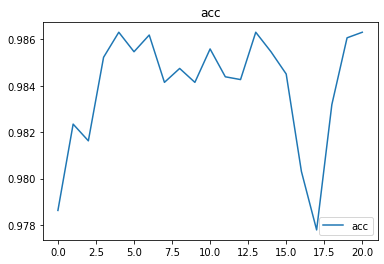

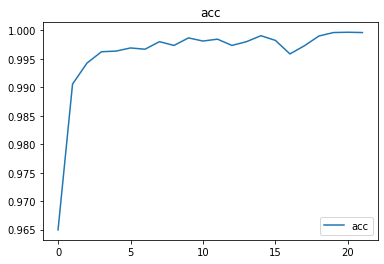

In [10]:
### schedule epoch = 50
plotResultCurve(_metrics,['acc'],'acc')
plotResultCurve(_metrics_train,['acc'],'acc')

In [ ]:
### schedule epoch = 30
plotResultCurve(_metrics,['acc'],'acc')
plotResultCurve(_metrics_train,['acc'],'acc') 

处理

In [6]:
def RemoveImgInFolder(path_dir, ratio):
    # path文件夹路径，ratio删除比例
    filelist = os.listdir(path_dir)
    rmfilelist = random.sample(filelist, int(ratio*len(filelist)))
    for idx,f in enumerate(rmfilelist):
        filepath = os.path.join(path_dir, f)
        if os.path.isfile(filepath):
            os.remove(filepath)
            if idx%1000==1:
                print('remove ',idx)
    return

def ImgSummary(path_dirs):
    filelists = [ os.listdir(x) for x in path_dirs ]
    _ = [print(p,len(x)) for x,p in zip(filelists,path_dirs)]
    return

In [ ]:
RemoveImgInFolder(WORK_DIR+'/traindata/2',ratio=0.7179622774546095)

In [7]:
# savePath = checkpoint(net, optimizer, __SAVE_EPOCH, useTimeDir=True)
# saveResult(_metrics,savePath)
# saveParameters(savePath)

ImgSummary([
    WORK_DIR+'/traindata/0',
    WORK_DIR+'/traindata/1',
    WORK_DIR+'/traindata/2',
    WORK_DIR+'/traindata/3',
    WORK_DIR+'/traindata/4',
           ])

# 1-8000/28365

/root/research/jupyter/git-metallic-5-5/metallic/traindata/0 8000
/root/research/jupyter/git-metallic-5-5/metallic/traindata/1 8000
/root/research/jupyter/git-metallic-5-5/metallic/traindata/2 8000
/root/research/jupyter/git-metallic-5-5/metallic/traindata/3 4317
/root/research/jupyter/git-metallic-5-5/metallic/traindata/4 8000
